<a href="https://colab.research.google.com/github/FarahYusri12/Warfarin_Dosing_Prediction-Model_Comparison/blob/main/Decision_tree_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('Preprocessed_data.csv')
print(df.head())
print("\n" + "+"*100 + "\n")
print(df.info())

            ID Age (years)  Gender  Weight (kg)  Height (cm)  Dose (mg)  \
0  PA135312261     60 - 69    Male        115.7       193.04       49.0   
1  PA135312262     50 - 59  Female        144.2       176.53       42.0   
2  PA135312263     40 - 49  Female         77.1       162.56       53.0   
3  PA135312264     60 - 69    Male         90.7       182.24       28.0   
4  PA135312265     50 - 59    Male         72.6       167.64       42.0   

  CYP2C9 VKORC1 (rs9923231; C/T)  Gender_code  CYP2C9_code  VKORC1_code   Age  
0  *1/*1                     A/G            1            0            1  64.5  
1  *1/*1                     A/A            0            0            2  54.5  
2  *1/*1                     G/G            0            0            0  44.5  
3  *1/*1                     A/G            1            0            1  64.5  
4  *1/*3                     A/G            1            1            1  54.5  

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [2]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Separate data

x=df[['Age', 'Gender_code', 'Weight (kg)', 'Height (cm)', 'CYP2C9_code', 'VKORC1_code']]
y=df['Dose (mg)']

# train-test split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=42)

In [4]:
#=================
# pipeline setup
#=================

pipeline= Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeRegressor(random_state=42))
])



In [5]:
#============================
# GridSearchCV for hyperparameter tuning
#============================

param_grid={
    'tree__max_depth': [2,3,4,5,None],
    'tree__min_samples_split': [2,3,4,]
}

grid= GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid.fit(x_train, y_train)

print("Best Parameter:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best Parameter: {'tree__max_depth': 3, 'tree__min_samples_split': 2}
Best CV score: 0.3043272632230397


In [6]:
#===================
# Evaluation
#===================

best_model= grid.best_estimator_
y_pred= best_model.predict(x_test)

mae=mean_absolute_error(y_test, y_pred)
mse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)

print("Model performance:")
print(f"Mae : {mae:.2f}")
print(f"Rmse: {mse:.2f}")
print(f"R2  : {r2:.2f}")

Model performance:
Mae : 9.42
Rmse: 13.20
R2  : 0.38


In [7]:
#==========================
# Permutation Important
#==========================

perm_important=permutation_importance(
    best_model,
    x_test,
    y_test,
    n_repeats=10,
    random_state=42,

)
feature_important= pd.DataFrame({
    'Feature':x_test.columns,
    'Importance_mean':perm_important.importances_mean,
    'Importance_std': perm_important.importances_std
}).sort_values(by='Importance_mean', ascending=False)

print("permutation importance:")
print(feature_important)

permutation importance:
       Feature  Importance_mean  Importance_std
5  VKORC1_code         0.579883        0.022567
0          Age         0.096039        0.021066
4  CYP2C9_code         0.020523        0.005227
3  Height (cm)         0.006219        0.009050
1  Gender_code         0.000000        0.000000
2  Weight (kg)         0.000000        0.000000


In [8]:

print("Train R2:", best_model.score(x_train, y_train))
print("Test  R2:", best_model.score(x_test, y_test))


Train R2: 0.34437021430609127
Test  R2: 0.3791593906317028


Visualization

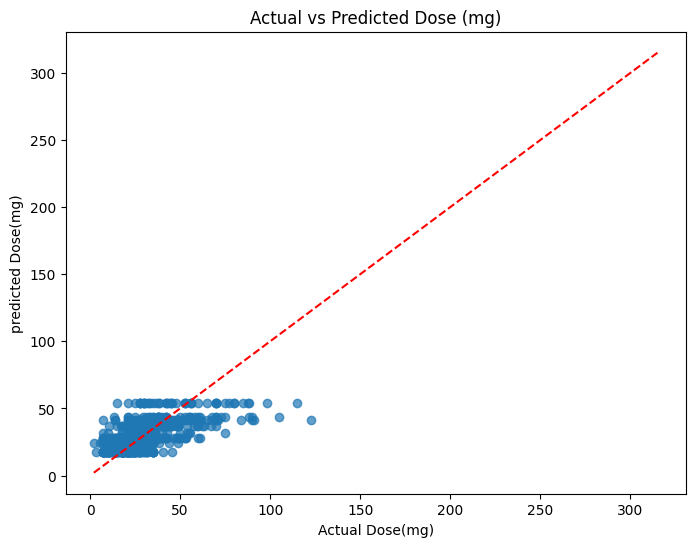

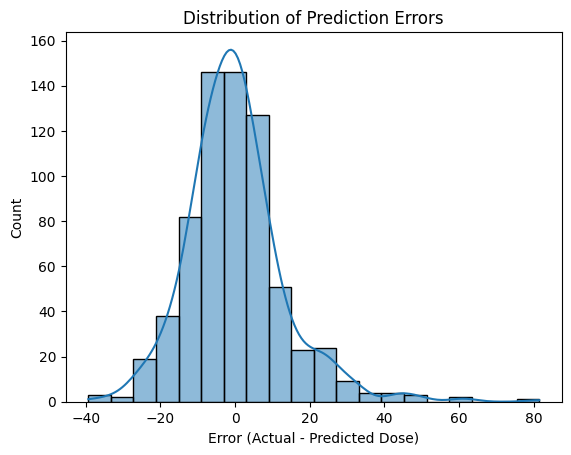

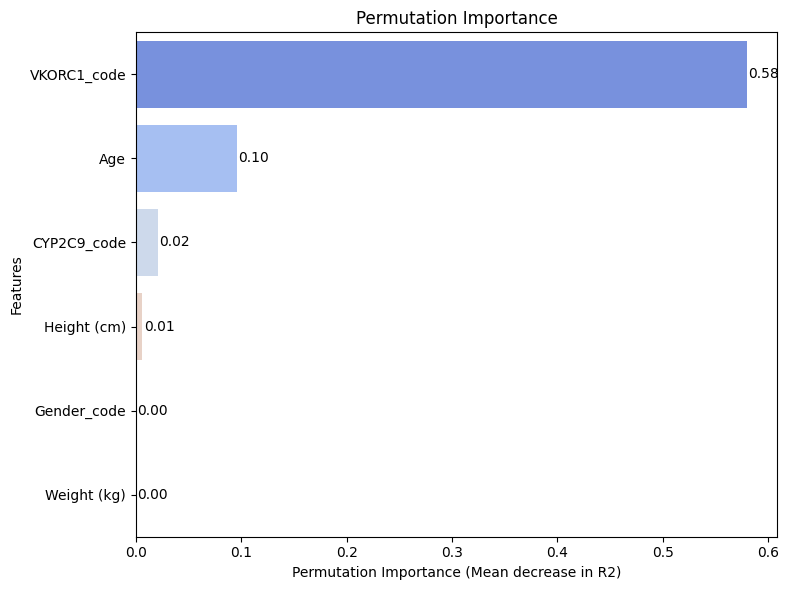

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Dose(mg)")
plt.ylabel("predicted Dose(mg)")
plt.title("Actual vs Predicted Dose (mg)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.show()

print("\n" + "="*100 + "\n")

# Distribution plot error
errors=y_test-y_pred
sns.histplot(errors, bins=20, kde=True)
plt.xlabel("Error (Actual - Predicted Dose)")
plt.title("Distribution of Prediction Errors")
plt.show()

print("\n" + "="*100 + "\n")

# Permutation Importance bar plot
plt.figure(figsize=(8,6))
ax=sns.barplot(
    x="Importance_mean",
    y="Feature",
    data=feature_important,
    hue="Feature",
    palette="coolwarm",
    legend=False
)

plt.xlabel("Permutation Importance (Mean decrease in R2)")
plt.ylabel("Features")
plt.title("Permutation Importance")
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=1)

plt.tight_layout()
plt.show()